In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
def plot_sample_images(train_loader, class_names, num_samples=5):
    sample_batch, sample_labels = next(iter(train_loader))
    plt.figure(figsize=(10, 10))

    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(sample_batch[i].squeeze().numpy(), cmap='gray')
        plt.title(f"Label: {class_names[sample_labels[i]]}")
        plt.axis('off')
    plt.show()

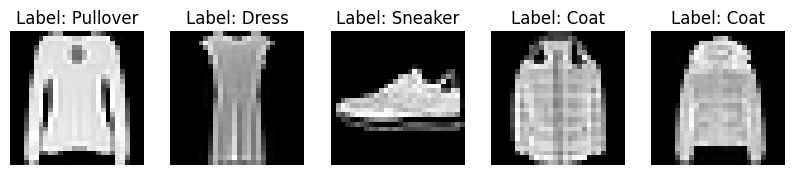

In [5]:
plot_sample_images(train_loader, train_dataset.classes)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
def square_mask(images, mask_size):
    batch_size, channels, height, width = images.size()
    mask = torch.zeros(batch_size, 1, height, width, dtype=torch.float32, device=images.device)

    center_h = height // 2
    center_w = width // 2

    start_h = max(center_h - mask_size // 2, 0)
    end_h = min(center_h + mask_size // 2, height)
    start_w = max(center_w - mask_size // 2, 0)
    end_w = min(center_w + mask_size // 2, width)

    mask[:, :, start_h:end_h, start_w:end_w] = 1
    return mask

In [8]:
def plot_masked_images(train_loader, mask_size=10, num_samples=5):
    sample_original, _ = next(iter(train_loader))
    sample_masked = sample_original.clone()
    mask = square_mask(sample_masked, mask_size)
    sample_masked[mask == 1] = 0
    fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(10, 10))

    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(sample_masked[i, 0], cmap='gray')
        ax.set_title('Masked')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

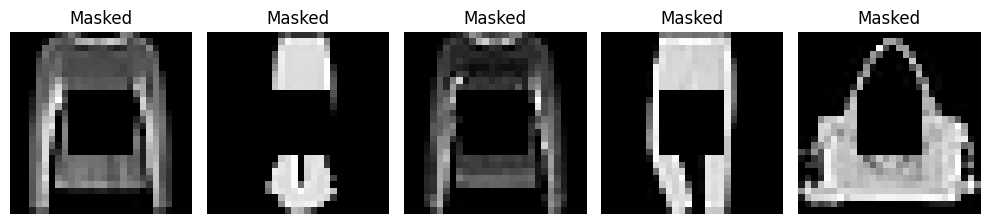

In [9]:
plot_masked_images(train_loader)

In [10]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
mask_size = 10

def train_model(model, train_dataloader, optimizer, criterion, num_epochs, mask_size, device):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in train_dataloader:
            images = images.to(device)

            mask = square_mask(images, mask_size)
            masked_images = images.clone()
            masked_images[mask == 1] = 0

            outputs = model(masked_images)

            loss = criterion(outputs, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        losses.append(epoch_loss)
        print(f'Training Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return losses

In [11]:
train_losses = train_model(model, train_loader, optimizer, criterion, num_epochs, mask_size, device)

Training Epoch [1/20], Loss: 0.0277
Training Epoch [2/20], Loss: 0.0116
Training Epoch [3/20], Loss: 0.0099
Training Epoch [4/20], Loss: 0.0090
Training Epoch [5/20], Loss: 0.0084
Training Epoch [6/20], Loss: 0.0080
Training Epoch [7/20], Loss: 0.0077
Training Epoch [8/20], Loss: 0.0075
Training Epoch [9/20], Loss: 0.0073
Training Epoch [10/20], Loss: 0.0072
Training Epoch [11/20], Loss: 0.0070
Training Epoch [12/20], Loss: 0.0069
Training Epoch [13/20], Loss: 0.0069
Training Epoch [14/20], Loss: 0.0068
Training Epoch [15/20], Loss: 0.0067
Training Epoch [16/20], Loss: 0.0066
Training Epoch [17/20], Loss: 0.0066
Training Epoch [18/20], Loss: 0.0065
Training Epoch [19/20], Loss: 0.0065
Training Epoch [20/20], Loss: 0.0064


In [12]:
def plot_losses(train_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

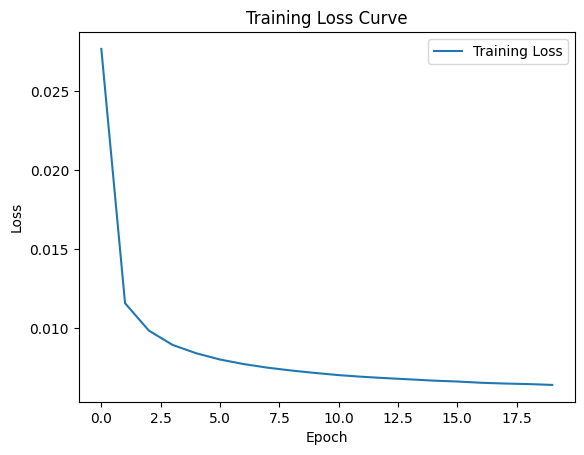

In [13]:
plot_losses(train_losses)

In [20]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def visualize_images(original_images, masked_images, reconstructed_images, labels, num_images=5):
    original_images = torch.from_numpy(original_images[:num_images])
    masked_images = torch.from_numpy(masked_images[:num_images])
    reconstructed_images = torch.from_numpy(reconstructed_images[:num_images])

    grid_images = torch.cat([original_images, masked_images, reconstructed_images], dim=0)
    grid = make_grid(grid_images, nrow=5, padding=5, pad_value=1)

    plt.figure(figsize=(15, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')

    plt.title('Original, Masked, and Reconstructed Images')

    plt.show()


In [21]:
def test_examples(model, train_loader, device, mask_size):
    model.eval()
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)

            mask = square_mask(images, mask_size)
            masked_images = images.clone()
            masked_images[mask == 1] = 0

            outputs = model(masked_images)

            visualize_images(images.cpu().numpy(), masked_images.cpu().numpy(), outputs.cpu().numpy(), labels)
            break


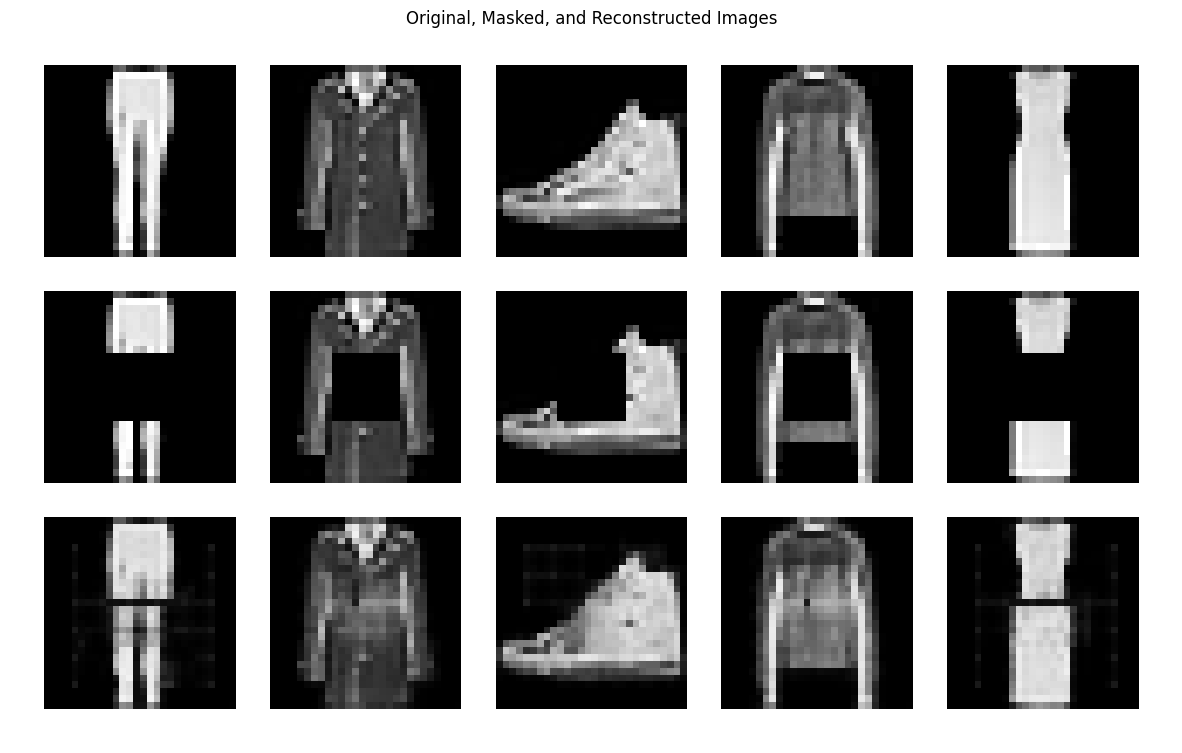

In [22]:
test_examples(model, train_loader, device, mask_size)